## Multi-label prediction with Traditional Decor Patterns

Kaggle dataset Traditional Decor Patterns

In [5]:
from fastai.vision import *

In [6]:
path = Config.data_path()/'decor'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/channing_platevoet/.fastai/data/decor')

In [7]:
! kaggle datasets download -d olgabelitskaya/traditional-decor-patterns -f decor.csv -p {path}
! kaggle datasets download -d olgabelitskaya/traditional-decor-patterns -f decor.zip -p {path}
! kaggle datasets download -d olgabelitskaya/traditional-decor-patterns -f DecorColorImages.h5 -p {path}

  0%|                                               | 0.00/22.6k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 22.6k/22.6k [00:00<00:00, 18.5MB/s]
 23%|████████▋                             | 5.00M/21.9M [00:00<00:00, 22.4MB/s]
100%|██████████████████████████████████████| 21.9M/21.9M [00:00<00:00, 78.2MB/s]
 95%|████████████████████████████████████▏ | 25.0M/26.3M [00:00<00:00, 56.9MB/s]
100%|███████████████████████████████████████| 26.3M/26.3M [00:00<00:00, 103MB/s]


In [11]:
df = pd.read_csv(path/'decor.csv')
#df['tags'] = df['country'] +' '+ df['decor'] +' '+ df['type']
df['tags'] = df[['country', 'decor', 'type']].apply(lambda x: ' '.join(x), axis=1)
df.to_csv(path/'decor.csv') 
df.head()

,country_label,country,decor_label,decor,type_label,type,file,tags
0,1,Russia,1,Gzhel,1,pattern,01_01_1_001.png,Russia Gzhel pattern
1,1,Russia,1,Gzhel,1,pattern,01_01_1_002.png,Russia Gzhel pattern
2,1,Russia,1,Gzhel,1,pattern,01_01_1_003.png,Russia Gzhel pattern
3,1,Russia,1,Gzhel,1,pattern,01_01_1_004.png,Russia Gzhel pattern
4,1,Russia,1,Gzhel,1,pattern,01_01_1_005.png,Russia Gzhel pattern


In [12]:
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(max_lighting=0.1, max_zoom=1.02) # Stan's

In [13]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'decor.csv', cols='file')
       .split_by_rand_pct(0.2)
       .label_from_df(cols='tags', label_delim=' '))

In [14]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'decor.csv', cols='file')
       .split_by_rand_pct(0.2)
       .label_from_df(cols='tags', label_delim=' '))

In [16]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

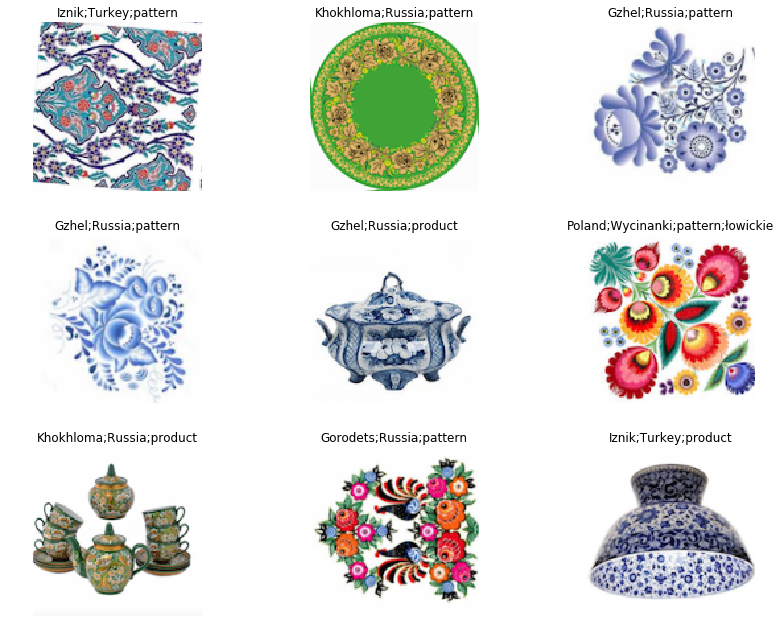

In [17]:
data.show_batch(rows=3, figsize=(12,9))

In [18]:
arch = models.resnet50

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/channing_platevoet/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 51283564.75it/s]


In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


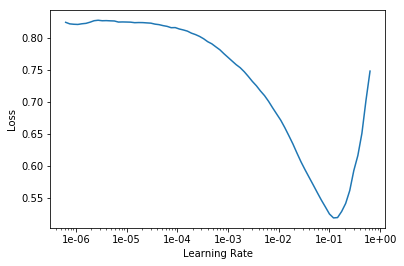

In [21]:
learn.recorder.plot()

In [22]:
lr = 0.01

In [23]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.734972,0.523426,0.364948,0.623106,00:02
1,0.593509,0.381732,0.615120,0.723495,00:01
2,0.464991,0.166846,0.880412,0.887606,00:01
3,0.367059,0.135162,0.943643,0.920477,00:01
4,0.303214,0.134006,0.945705,0.915420,00:01


In [24]:
learn.save('decor-1-rn50')

In [30]:
learn.load('decor-1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (388 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Russia;Gzhel;pattern,Russia;Gzhel;pattern,Russia;Gzhel;pattern,Russia;Gzhel;pattern,Russia;Gzhel;pattern
Path: /home/channing_platevoet/.fastai/data/decor;

Valid: LabelList (97 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Turkey;Iznik;product,Belarus;Neglyubka;product,Russia;Khokhloma;product,Belarus;Neglyubka;pattern,Turkey;Iznik;product
Path: /home/channing_platevoet/.fastai/data/decor;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, cei

finetune the model

In [31]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


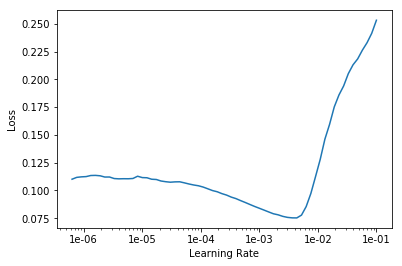

In [32]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.101460,0.109642,0.950516,0.936384,00:01
1,0.107442,1.920169,0.819244,0.712579,00:01
2,0.103220,0.504145,0.904467,0.821744,00:01
3,0.097714,0.274319,0.951203,0.907277,00:01
4,0.084889,0.080493,0.971821,0.955897,00:01


In [33]:
learn.save('decor-2-rn50')

Retrain model with size=150

In [34]:
data = (src.transform(tfms, size=150)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 150, 150])

In [35]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


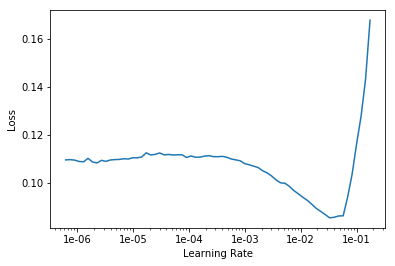

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
lr=1e-2

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.105504,0.107098,0.942268,0.944556,00:02
1,0.096753,0.081651,0.958763,0.941023,00:01
2,0.088960,0.087525,0.957388,0.936161,00:01
3,0.077808,0.087843,0.958763,0.939491,00:01
4,0.067412,0.083108,0.959450,0.942858,00:01


In [39]:
learn.save('decor-1-150-rn50')

In [40]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


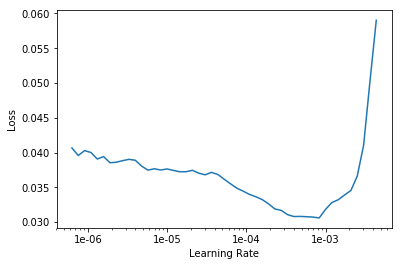

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.035867,0.072250,0.966323,0.943924,00:02
1,0.033932,0.071720,0.973883,0.961705,00:02
2,0.031536,0.067230,0.975945,0.963380,00:02
3,0.029139,0.048056,0.978007,0.965388,00:02
4,0.025411,0.046095,0.978007,0.965388,00:02


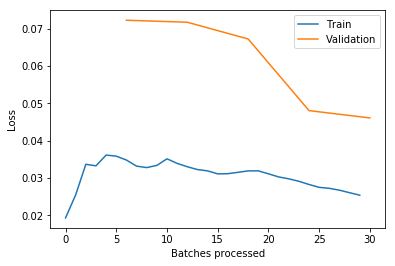

In [43]:
learn.recorder.plot_losses()